# RecoFlow Example

Matrix Factorisation - Linear with Bias: This is the classical collaborative filtering model with addition of bias

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import numpy as np
import pandas as pd
#from IPython.display import SVG, display
import matplotlib.pyplot as plt

In [3]:
%matplotlib inline

### Prepare the data

In [4]:
df_ratings = pd.read_csv("data/ratings.csv")
df_items= pd.read_csv("data/items.csv")

In [5]:
from recoflow.preprocessing import EncodeUserItem

In [6]:
interaction, n_users, n_items, user_encoder, item_encoder = EncodeUserItem(df_ratings, "user_id", "movie_id", "rating", "unix_timestamp")

Number of users:  943
Number of items:  1682


In [7]:
interaction.head()

,user_id,movie_id,RATING,TIMESTAMP,USER,ITEM
0,196,242,3,881250949,195,241
1,186,302,3,891717742,185,301
2,22,377,1,878887116,21,376
3,244,51,2,880606923,243,50
4,166,346,1,886397596,165,345


In [8]:
n_users, n_items

(943, 1682)

In [9]:
max_rating = interaction.RATING.max()
min_rating = interaction.RATING.min()
min_rating, max_rating

(1, 5)

In [10]:
from recoflow.preprocessing import RandomSplit, StratifiedSplit, ChronoSplit

In [11]:
# Data Splitting
train, test = StratifiedSplit(interaction, [0.8, 0.2], by="USER")

In [12]:
train.shape, test.shape

((80000, 7), (20000, 7))

## Explicit Matrix Factorisation 

This is a model with User and Item Embedding Dot Product + adjustment for user bias

### Build the Model

In [13]:
from recoflow.models import ExplicitMatrixFactorisationBias
from recoflow import vis

In [14]:
n_factors = 40
model = ExplicitMatrixFactorisationBias(n_users, n_items, n_factors, max_rating, min_rating)

In [15]:
model.summary()

Model: "ExplicitMatrixFactorisationBias"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Item (InputLayer)             │ (None, 1)                 │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ User (InputLayer)             │ (None, 1)                 │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ ItemEmbedding (Embedding)     │ (None, 1, 40)             │          67,280 │ Item[0][0]                 │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ UserEmbedding (Embedding)     │ (None, 1, 40)             │          37,720 │ User[0][0]                 │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ FlattenItemE (Flatten)        │ (None, 40)                │               0 │ ItemEmbedding[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ FlattenUserE (Flatten)        │ (None, 40)                │               0 │ UserEmbedding[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ ItemBias (Embedding)          │ (None, 1, 1)              │           1,682 │ Item[0][0]                 │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ UserBias (Embedding)          │ (None, 1, 1)              │             943 │ User[0][0]                 │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ DotProduct (Dot)              │ (None, 1)                 │               0 │ FlattenItemE[0][0],        │
│                               │                           │                 │ FlattenUserE[0][0]         │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ FlattenItemBiasE (Flatten)    │ (None, 1)                 │               0 │ ItemBias[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ FlattenUserBiasE (Flatten)    │ (None, 1)                 │               0 │ UserBias[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ AddBias (Add)                 │ (None, 1)                 │               0 │ DotProduct[0][0],          │
│                               │                           │                 │ FlattenItemBiasE[0][0],    │
│                               │                           │                 │ FlattenUserBiasE[0][0]     │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ activation (Activation)       │ (None, 1)                 │               0 │ AddBias[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ lambda (Lambda)               │ (None, 1)                 │               0 │ activation[0][0]           │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 107,625 (420.41 KB)

 Trainable params: 107,625 (420.41 KB)

 Non-trainable params: 0 (0.00 B)

In [16]:
from keras.utils import plot_model

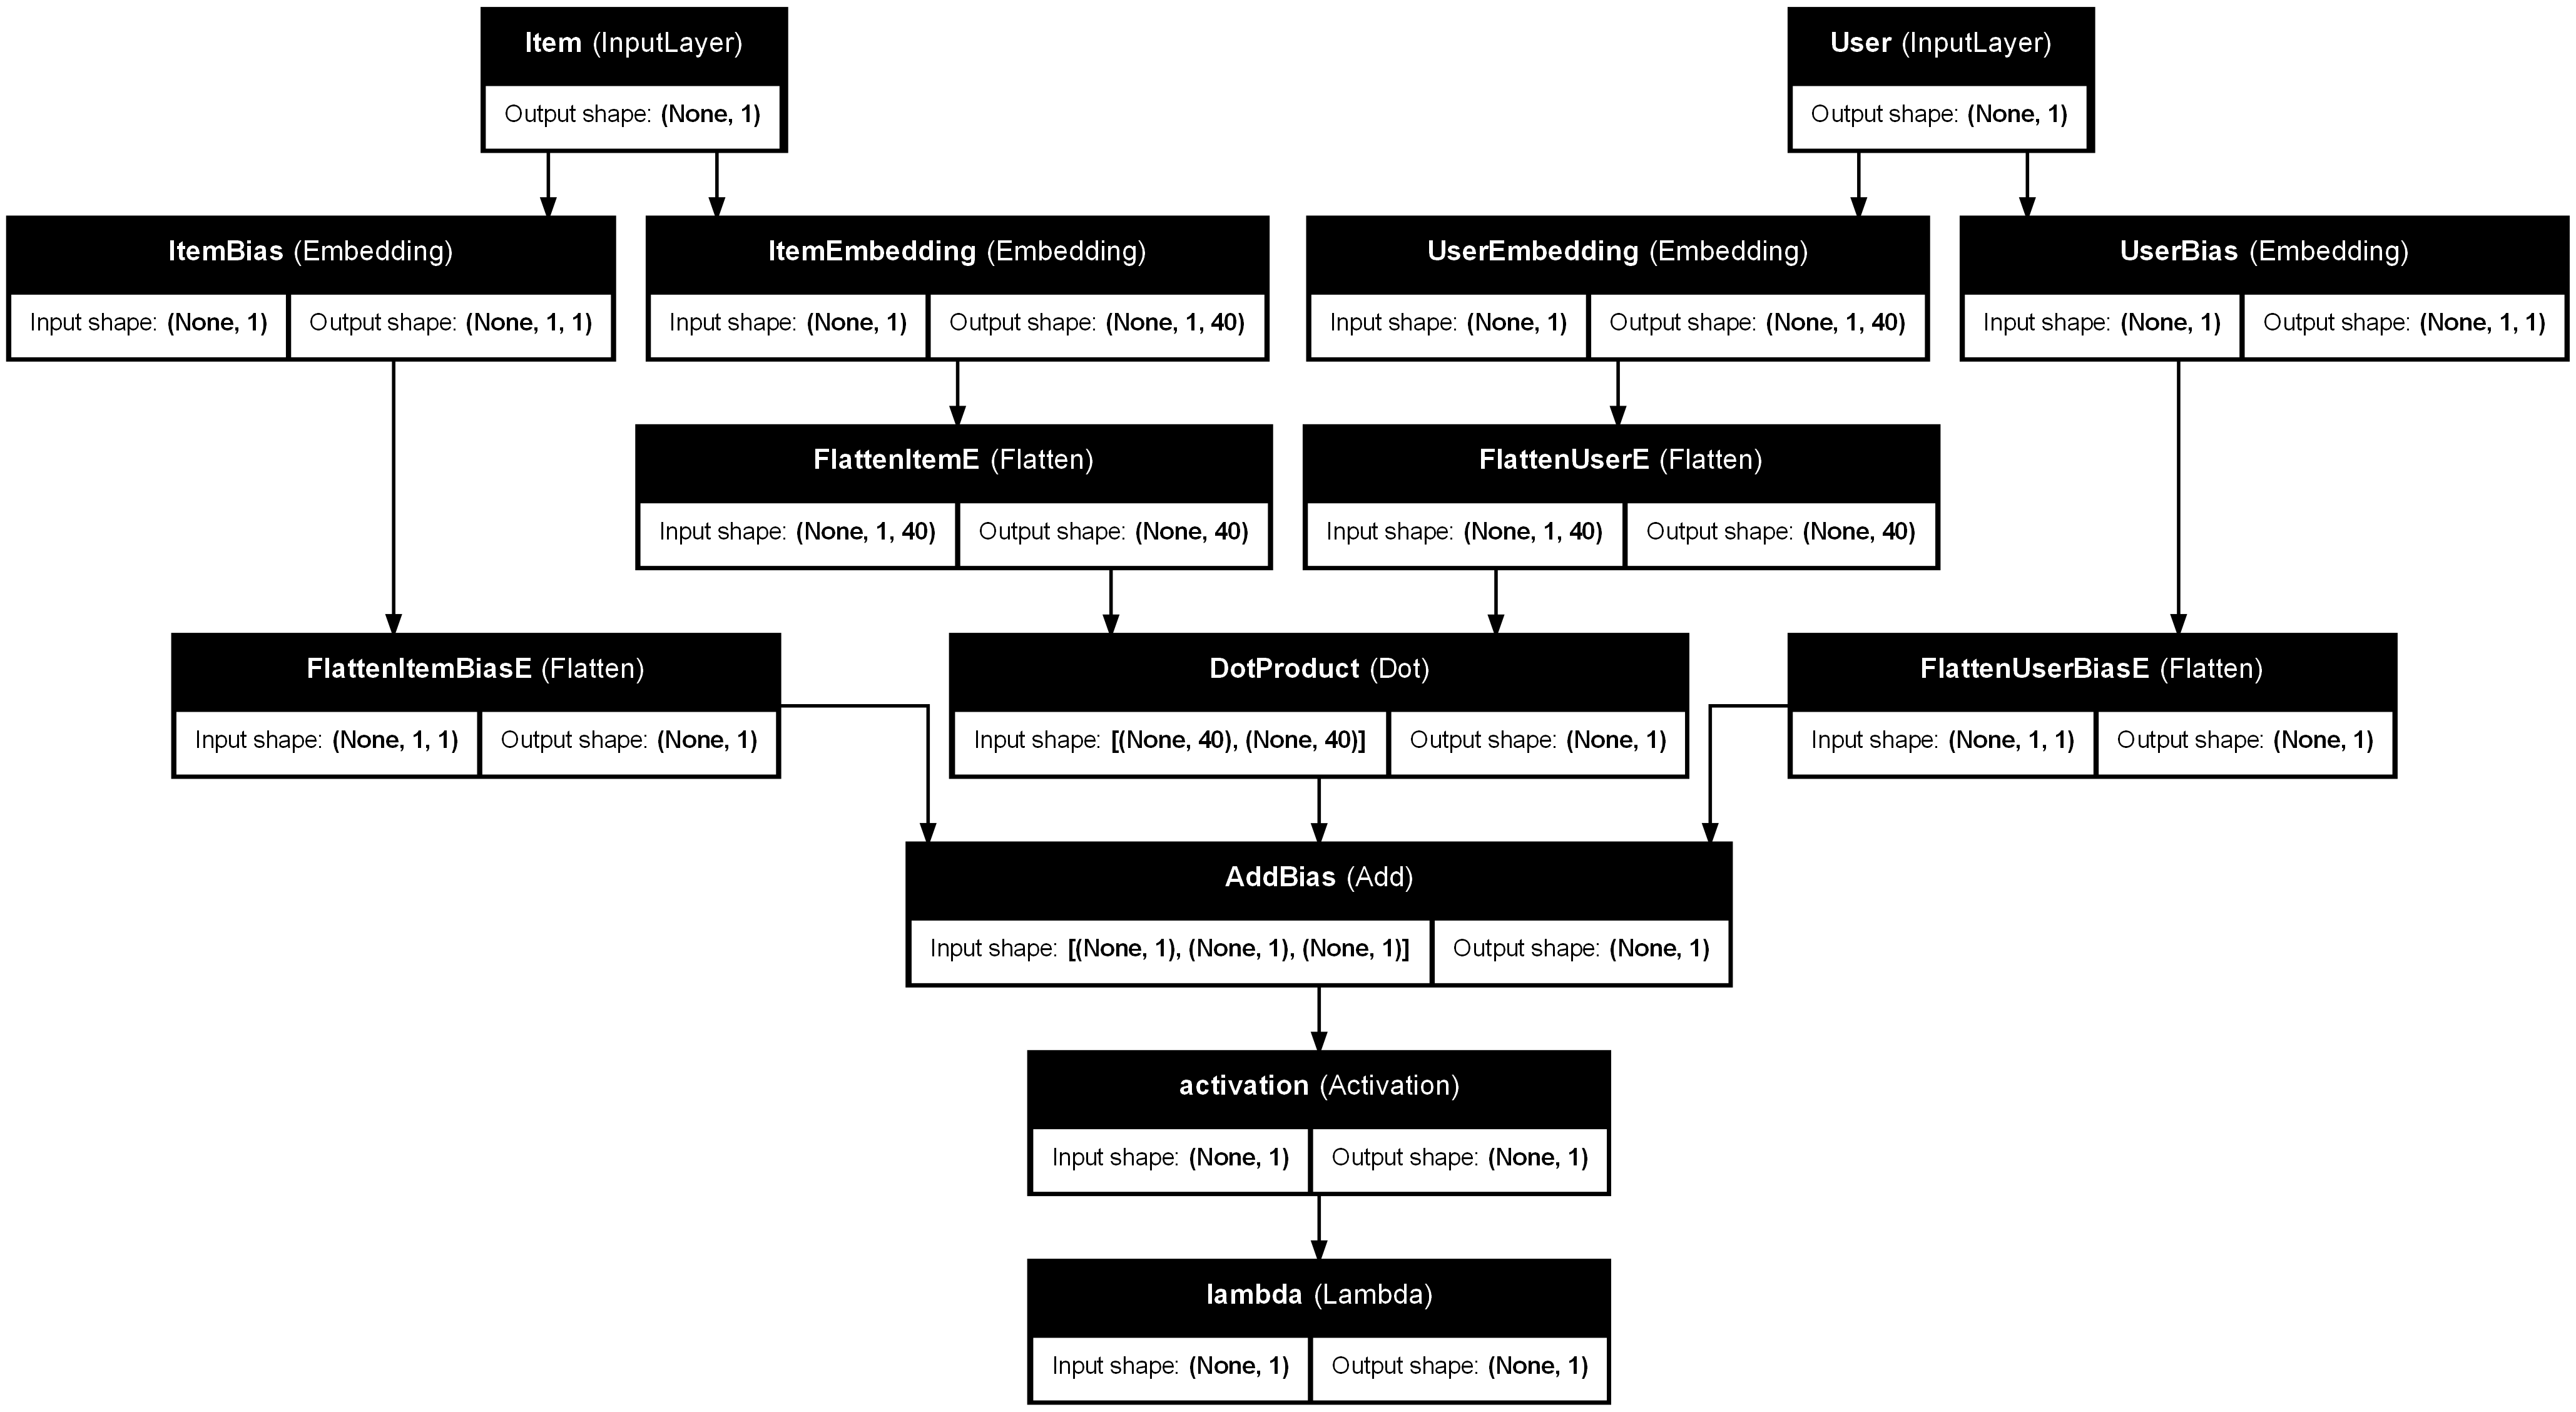

In [17]:
plot_model(model, show_layer_names=True, show_shapes=True)

### Train the Model

In [18]:
from recoflow.utils import CreateDirectory

In [19]:
CreateDirectory('models')

Directory already exists C:\Users\sadha\OneDrive\Desktop\Movie Recommendation System/models


In [20]:
from keras.callbacks import ModelCheckpoint, History

In [21]:
checkpointer = ModelCheckpoint(filepath="models/EMFBiasWeights.hdf5", verbose=1, save_best_only=True)
modelmetrics = History()

ValueError: The filepath provided must end in `.keras` (Keras model format). Received: filepath=models/EMFBiasWeights.hdf5

In [ ]:
%%timeit -n1 -r1 -o
model.fit([train.USER, train.ITEM], train.RATING, batch_size=256, epochs=2, verbose=1, 
                   validation_data=([test.USER, test.ITEM], test.RATING), 
                   callbacks=[checkpointer, modelmetrics])

In [ ]:
training_time = _.timings[0]

In [ ]:
training_time

In [ ]:
vis.metrics(modelmetrics.history)

### Score the Model

In [ ]:
model.load_weights("models/EMFBiasWeights.hdf5")

In [ ]:
score = model.evaluate([test.USER, test.ITEM], test.RATING, verbose=1)
score

### Evaluate the Model

In [ ]:
from timeit import default_timer
from recoflow.recommend import GetPredictions, GetRankingTopK

In [ ]:
%%time
predictions = GetPredictions(model, interaction)

In [ ]:
predictions.shape

In [ ]:
%%time
# Recommendation for Top10K
ranking_topk = GetRankingTopK(model, interaction, train, k=5)

In [ ]:
%%time
start_time = default_timer()
end_time = default_timer()
print(end_time-start_time)

In [ ]:
predictions.head()

In [ ]:
ranking_topk.head(10)

In [ ]:
from recoflow.metrics import MeanAbsoluteError, MeanSquaredError, RootMeanSquaredError
from recoflow.metrics import PrecisionK, RecallK, NDCGK, MeanAveragePrecisionK, MeanReciprocalRankK

In [ ]:
( MeanSquaredError(test, predictions), 
  RootMeanSquaredError(test, predictions), 
  MeanAbsoluteError(test, predictions)
)

In [ ]:
def ranking_metrics(test, ranking_topk, k=5):
    
    return ( PrecisionK(test, predictions, k),
  RecallK(test, predictions,k),
  NDCGK(test, predictions,k),
  MeanAveragePrecisionK(test, predictions, k),
  MeanReciprocalRankK(test, predictions,k)
)

In [ ]:
ranking_metrics(test, predictions)

In [ ]:
ranking_metrics(test, ranking_topk)

In [ ]:
ranking_metrics(test1, prediction1)

In [ ]:
test1 = test[test.USER == 1]
prediction1 = predictions[predictions.USER==1]

In [ ]:
test1.ITEM.tolist()

In [ ]:
prediction1.ITEM.tolist()

In [ ]:
from recoflow.metrics import _GetHitDF

In [ ]:
df_hit, df_hit_count, n_users = _GetHitDF(test, predictions, 5)

In [ ]:
test.head()

In [ ]:
train[train.USER == 0].count()

In [ ]:
test[test.USER ==0].count()

In [ ]:
df_hit[df_hit.USER ==0]

In [ ]:
# Calculate Reciprocal Rank
df_hit_sorted = df_hit.copy()
df_hit_sorted["rRank"] = (df_hit_sorted.groupby("USER").cumcount() + 1) / df_hit_sorted["rank"]
df_hit_sorted = df_hit_sorted.groupby("USER").agg({"rRank": "sum"}).reset_index()

In [ ]:
df_hit_sorted.

In [ ]:
df_hit_sorted["rRank"].sum() / n_users

In [ ]:
#from reco.evaluate import get_embedding, get_predictions, recommend_topk
#from reco.evaluate import precision_at_k, recall_at_k, ndcg_at_k

In [ ]:
from recoflow.recommend import UserEmbedding, ItemEmbedding

In [ ]:
item_embedding = ItemEmbedding(model, "ItemEmbedding")
user_embedding = UserEmbedding(model, "UserEmbedding")

In [ ]:
item_embedding.shape

In [ ]:
from sklearn.neighbors import NearestNeighbors

In [ ]:
def GetSimilar(embedding, k):
    model_similar_items = NearestNeighbors(n_neighbors=k, algorithm="ball_tree").fit(embedding)
    distances, indices = model_similar_items.kneighbors(embedding)
    
    return distances, indices

In [ ]:
model_similar_items = NearestNeighbors(n_neighbors=10, metric="cosine").fit(item_embedding)
distances, indices = model_similar_items.kneighbors(item_embedding)
    

In [ ]:
indices[0]

In [ ]:
def show_similar(item_index, item_similar_indices, item_encoder):
        
    s = item_similar_indices[item_index]
    movie_ids = item_encoder.inverse_transform(s)

    images = []
    for movie_id in movie_ids:
        img_path = 'data/posters/' + str(movie_id) + '.jpg'
        images.append(mpimg.imread(img_path))

    plt.figure(figsize=(20,10))
    columns = 5
    for i, image in enumerate(images):
        plt.subplot(len(images) / columns + 1, columns, i + 1)
        plt.axis('off')
        plt.imshow(image)

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import PIL

In [ ]:
show_similar(0, indices, item_encoder)

In [ ]:
GetSimilar

In [ ]:
%%time
predictions = get_predictions(model, DATA)

In [ ]:
predictions.head()

In [ ]:
%%time
# Recommendation for Top10K
ranking_topk = recommend_topk(model, DATA, train, k=5)

In [ ]:
eval_precision = precision_at_k(test, ranking_topk, k=10)
eval_recall = recall_at_k(test, ranking_topk, k=10)
eval_ndcg = ndcg_at_k(test, ranking_topk, k=10)

print("NDCG@K:\t%f" % eval_ndcg,
      "Precision@K:\t%f" % eval_precision,
      "Recall@K:\t%f" % eval_recall, sep='\n')

### Get Similar Items

In [ ]:
from reco.recommend import get_similar, show_similar

In [ ]:
%%time
item_distances, item_similar_indices = get_similar(item_embedding, 5)

In [ ]:
item_similar_indices

In [ ]:
show_similar(0, item_similar_indices, item_encoder)

# Implicit

In [ ]:
from scipy.sparse import coo_matrix

In [ ]:
data = pd.read_csv("data/ratings.csv")

In [ ]:
data.head()

In [ ]:
# map each artist and user to a unique numeric value
data['user'] = data['user_id'].astype("category")
data['item'] = data['movie_id'].astype("category")

In [ ]:
# Convert ratings to 
data["implicit_rating"] = data["rating"].apply(lambda x: 1 if x >= 4 else 0)

In [ ]:
data.head()

In [ ]:
# create a sparse matrix of all the artist/user/play triples
item_user_data = coo_matrix((data['implicit_rating'].astype(float), 
                   (data['item'].cat.codes, 
                    data['user'].cat.codes)))

In [ ]:
import implicit

In [ ]:
# initialize a model
model = implicit.als.AlternatingLeastSquares(factors=50)

# train the model on a sparse matrix of item/user/confidence weights
model.fit(item_user_data)

In [ ]:
# recommend items for a user
user_items = item_user_data.T.tocsr()
recommendations = model.recommend(196, user_items)

In [ ]:
# find related items
related = model.similar_items(71)

In [ ]:
related_i = [x[0] for x in related]
related_i

In [ ]:
df_items[df_items.movie_id.isin(related_i)].title